In [9]:
# pip install -q scikit-learn litellm trulens_eval


Note: you may need to restart the kernel to use updated packages.


In [1]:
# Import groundedness feedback function
from trulens_eval import Tru
from test_cases import generate_ms_marco_context_relevance_benchmark
from benchmark_frameworks.eval_as_recommendation import score_passages, compute_ndcg, compute_ece, recall_at_k, precision_at_k
Tru().reset_database()

benchmark_data = []
for i in range(1, 6):
    dataset_path = f"./datasets/ms_marco/ms_marco_train_v2.1_{i}.json"
    benchmark_data.extend(list(generate_ms_marco_context_relevance_benchmark(dataset_path)))


🦑 Tru initialized with db url sqlite:///default.sqlite .
🛑 Secret keys may be written to the database. See the `database_redact_keys` option of Tru` to prevent this.


In [2]:
import os
os.environ["OPENAI_API_KEY"] = "..."
os.environ["ANTHROPIC_API_KEY"] = "..."

In [18]:
import pandas as pd
import numpy as np
df = pd.DataFrame(benchmark_data)
df = df.iloc[:500]
print(len(df.groupby("query_id").count()))

50


In [19]:
df.groupby("query_id").head()

,query_id,query,passage,is_selected,relevant_idx
0,1185869,)what was the immediate impact of the success ...,The presence of communication amid scientific ...,1,0
1,1185869,)what was the immediate impact of the success ...,The Manhattan Project and its atomic bomb help...,0,0
2,1185869,)what was the immediate impact of the success ...,Essay on The Manhattan Project - The Manhattan...,0,0
3,1185869,)what was the immediate impact of the success ...,The Manhattan Project was the name for a proje...,0,0
4,1185869,)what was the immediate impact of the success ...,versions of each volume as well as complementa...,0,0
...,...,...,...,...,...
490,520776,time change new zealand,"On 2 November 1868, New Zealand officially ado...",0,8
491,520776,time change new zealand,New Zealand Daylight Time (NZDT) is 13 hours a...,0,8
492,520776,time change new zealand,Country: New Zealand. Lat/Long: 36°51'S / 174°...,0,8
493,520776,time change new zealand,Time in New Zealand. New Zealand has two time ...,0,8


#### Define feedback functions for contexnt relevance to be evaluated

In [13]:
from trulens_eval.feedback import OpenAI, LiteLLM


# GPT 3.5
gpt3_turbo = OpenAI(model_engine="gpt-3.5-turbo")
def wrapped_relevance_turbo(input, output, temperature=0.0):
    return gpt3_turbo.context_relevance(input, output, temperature)

gpt4 = OpenAI(model_engine="gpt-4-1106-preview")
def wrapped_relevance_gpt4(input, output, temperature=0.0):
    return gpt4.context_relevance(input, output, temperature)

# # GPT 4 turbo latest
gpt4_latest = OpenAI(model_engine="gpt-4-0125-preview")
def wrapped_relevance_gpt4_latest(input, output, temperature=0.0):
    return gpt4_latest.context_relevance(input, output, temperature)


# Anthropic

claude_2 = LiteLLM(model_engine="claude-2")
def wrapped_relevance_claude2(input, output, temperature=0.0):
    return claude_2.context_relevance(input, output, temperature)

claude_2_1 = LiteLLM(model_engine="claude-2.1") 
def wrapped_relevance_claude21(input, output, temperature=0.0):
    return claude_2_1.context_relevance(input, output, temperature)


# Define a list of your feedback functions
feedback_functions = {
    'GPT-3.5-Turbo': wrapped_relevance_turbo,
    'GPT-4-Turbo': wrapped_relevance_gpt4,
    'GPT-4-Turbo-latest': wrapped_relevance_gpt4_latest,
    'Claude-2': wrapped_relevance_claude2,
    'Claude-2.1': wrapped_relevance_claude21,
}

backoffs_by_functions = {
    'GPT-3.5-Turbo': 0.5,
    'GPT-4-Turbo': 0.5,
    'GPT-4-Turbo-latest': 0.5,
    'Claude-2': 1,
    'Claude-2.1': 1,
}

In [ ]:

# Running the benchmark
results = []

K = 5 # for precision@K and recall@K
sample_size = 1 # sampling of size n is performed for estimating log probs (conditional probs) generated by the LLMs
for name, func in feedback_functions.items():
    try:
        scores, groundtruths = score_passages(df, name, func, backoffs_by_functions[name] if name in backoffs_by_functions else 0.5, n=1)
        
        df_score_groundtruth_pairs = pd.DataFrame({'scores': scores, 'groundtruth (human-preferences of relevancy)': groundtruths})
        df_score_groundtruth_pairs.to_csv(f"./results/{name}_score_groundtruth_pairs.csv")
        ndcg_value = compute_ndcg(scores, groundtruths)
        ece_value = compute_ece(scores, groundtruths)
        precision_k = np.mean([precision_at_k(sc, tr, 1) for sc, tr in zip(scores, groundtruths)])
        recall_k = np.mean([recall_at_k(sc, tr, K) for sc, tr in zip(scores, groundtruths)])
        results.append((name, ndcg_value, ece_value, recall_k, precision_k))
        print(f"Finished running feedback function name {name}")
    
        print("Saving results...")
        tmp_results_df = pd.DataFrame(results, columns=['Model', 'nDCG', 'ECE', f'Recall@{K}', 'Precision@1'])
        print(tmp_results_df)
        tmp_results_df.to_csv(f"./results/{name}_context_relevance_benchmark.csv")
        
    except Exception as e:
        print(f"Failed to run benchmark for feedback function name {name} due to {e}")
# Convert results to DataFrame for display
results_df = pd.DataFrame(results, columns=['Model', 'nDCG', 'ECE', f'Recall@{K}', 'Precision@1'])
results_df.to_csv(("./results/all_context_relevance_benchmark.csv"))

### Visualization

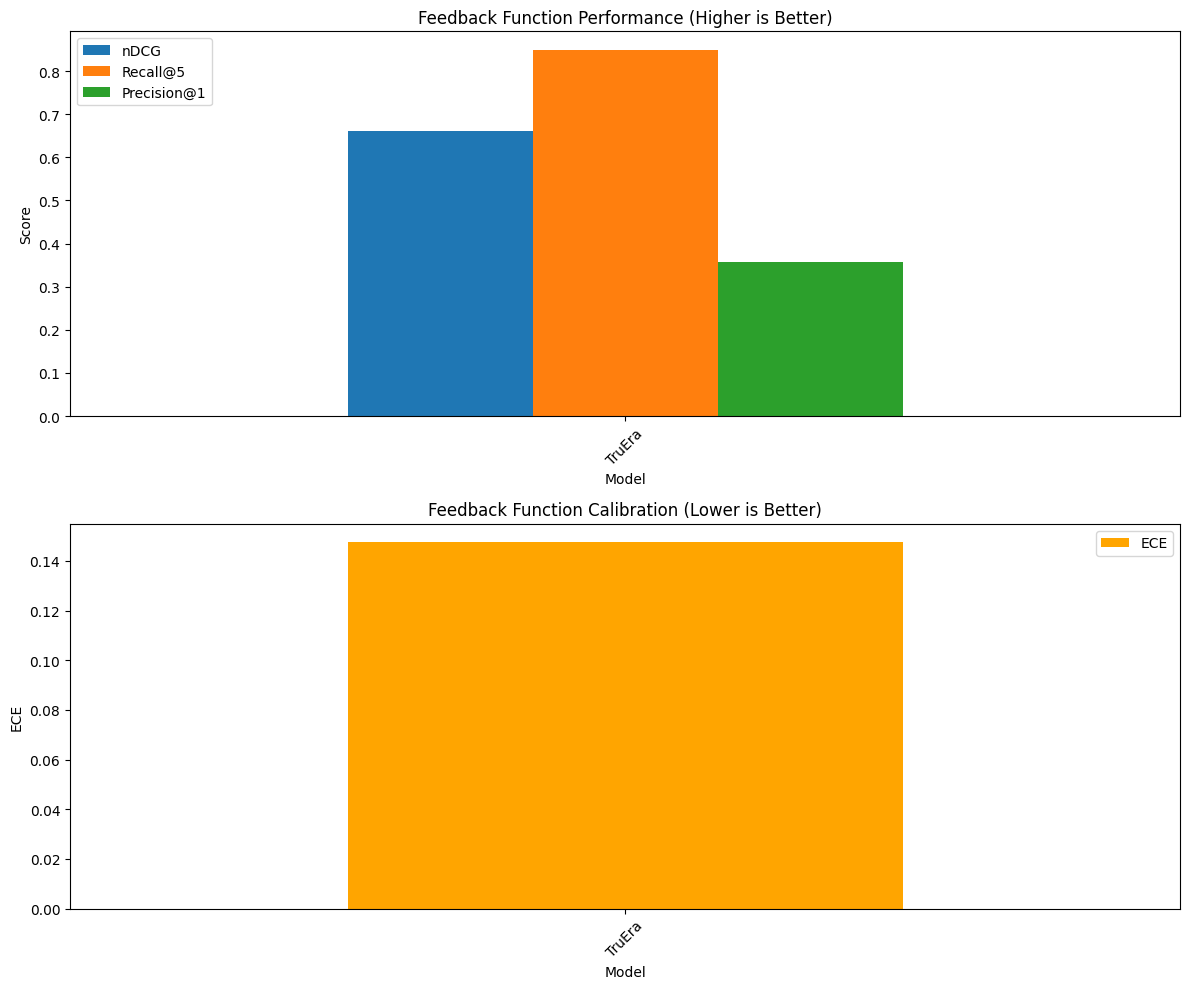

In [16]:

import matplotlib.pyplot as plt


# Make sure results_df is defined and contains the necessary columns
# Also, ensure that K is defined

plt.figure(figsize=(12, 10))

# Graph for nDCG, Recall@K, and Precision@K
plt.subplot(2, 1, 1)  # First subplot
ax1 = results_df_tru.plot(x='Model', y=['nDCG', f'Recall@{K}', 'Precision@1'], kind='bar', ax=plt.gca())
plt.title('Feedback Function Performance (Higher is Better)')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(loc='upper left')

# Graph for ECE
plt.subplot(2, 1, 2)  # Second subplot
ax2 = results_df_tru.plot(x='Model', y=['ECE'], kind='bar', ax=plt.gca(), color='orange')
plt.title('Feedback Function Calibration (Lower is Better)')
plt.ylabel('ECE')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()




In [1]:
import pandas as pd

# Replace these with your actual file paths
csv_file_1 = 'results_gpt.csv'
csv_file_2 = 'results_claude.csv'
# csv_file_3 = 'results_truera.csv'

# Read each CSV file into a DataFrame
df1 = pd.read_csv(csv_file_1)
df2 = pd.read_csv(csv_file_2)
# df3 = pd.read_csv(csv_file_3)

# Concatenate the DataFrames into a single DataFrame
results_df = pd.concat([df1, df2,], ignore_index=True)



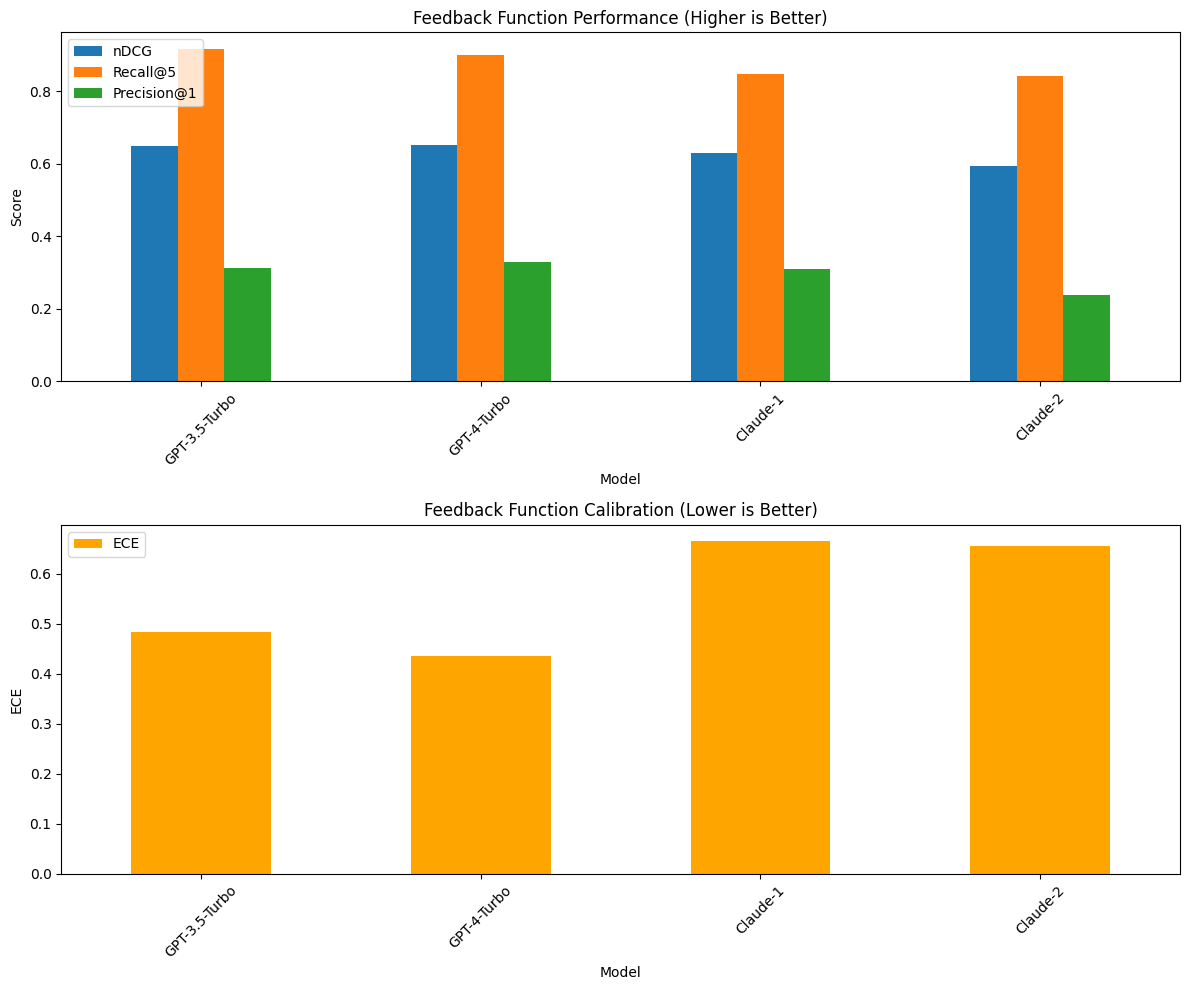

In [2]:
K = 5
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))

# Graph for nDCG, Recall@K, and Precision@K
plt.subplot(2, 1, 1)  # First subplot
ax1 = results_df.plot(x='Model', y=['nDCG', f'Recall@{K}', 'Precision@1'], kind='bar', ax=plt.gca())
plt.title('Feedback Function Performance (Higher is Better)')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(loc='upper left')

# Graph for ECE
plt.subplot(2, 1, 2)  # Second subplot
ax2 = results_df.plot(x='Model', y=['ECE'], kind='bar', ax=plt.gca(), color='orange')
plt.title('Feedback Function Calibration (Lower is Better)')
plt.ylabel('ECE')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()




In [3]:
results_df

,Unnamed: 0,Model,nDCG,ECE,Recall@5,Precision@1
0,0,GPT-3.5-Turbo,0.647704,0.482945,0.916940,0.311805
1,1,GPT-4-Turbo,0.653005,0.434865,0.898907,0.328607
2,0,Claude-1,0.630514,0.664760,0.846448,0.309567
3,1,Claude-2,0.592890,0.655371,0.843169,0.238918
